In [1]:
# some necessary imports
import os
import pickle
import json
from pprint import pprint
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

http://jmcauley.ucsd.edu/data/amazon/

In [2]:
df = pd.read_csv('amazon_reviews_sample100k_grocery.csv')

In [3]:
df.head()

,productId,Title,userId,Helpfulness,Score,Time,Text,Cat1,Cat2,Cat3
0,B0000DF3IX,Paprika Hungarian Sweet,A244MHL2UN2EYL,0/0,5.0,1127088000,While in Hungary we were given a recipe for Hu...,grocery gourmet food,herbs,spices seasonings
1,B0002QF1LK,Quaker Honey Graham Oh's 10.5 oz - (6 pack),A3FL7SXVYMC5NR,3/3,5.0,1138147200,"Without a doubt, I would recommend this wholes...",grocery gourmet food,breakfast foods,cereals
2,B0002QF1LK,Quaker Honey Graham Oh's 10.5 oz - (6 pack),A12IDQSS4OW33B,3/3,5.0,1118016000,This cereal is so sweet....yet so good for you...,grocery gourmet food,breakfast foods,cereals
3,B0002QF1LK,Quaker Honey Graham Oh's 10.5 oz - (6 pack),A2GZKHC1M4PKF4,2/2,3.0,1206489600,Man I love Oh's cereal. It is really great to ...,grocery gourmet food,breakfast foods,cereals
4,B0002QF1LK,Quaker Honey Graham Oh's 10.5 oz - (6 pack),AUGT2DOGKLHIN,2/2,5.0,1177545600,And I've tried alot of cereals. This is by far...,grocery gourmet food,breakfast foods,cereals


In [4]:
df.shape

(99982, 10)

In [5]:
df.columns

Index(['productId', 'Title', 'userId', 'Helpfulness', 'Score', 'Time', 'Text',
       'Cat1', 'Cat2', 'Cat3'],
      dtype='object')

From these 10 columns we'll use only 3 now:

- Text - review on the product
- Cat2 - label of category 2 for this product
- Cat3 - label of category 3 for this product


There's a taxonomy (hierarchical catalog) of all products with 3 categories (a.k.a. levels). Based on the review, we're going to classify it into one of level 2 categories (i.e. predicting Cat2) and level 3 categories (i.e. predicting Cat3).


We're not intrested anymore in Cat1 because here we chose only grocery. So we have 16 Cat2 categories and 157 Cat3 categories.

In [6]:
df['Cat1'].unique()

array([' grocery  gourmet food'], dtype=object)

In [7]:
df['Cat2'].value_counts()

pantry staples                       27291
beverages                            23440
snack food                           12724
candy chocolate                      11433
breakfast foods                       6248
breads  bakery                        4240
cooking  baking supplies              2444
herbs                                 2069
gourmet gifts                         1939
fresh flowers  live indoor plants     1811
baby food                             1270
meat  poultry                         1268
meat  seafood                         1250
produce                               1196
sauces  dips                           845
dairy  eggs                            514
Name: Cat2, dtype: int64

In [8]:
df['Cat3'].nunique()

157

## Simple text features
#### Bag of words
<img src ='tok.png'>
The easiest way to convert text to features is called Bag of Words: we create a vector with the length of the vocabulary, compute the number of occurrences of each word in the text, and place that number of occurrences in the appropriate position in the vector. The process described looks simpler in code:

In [9]:
texts = ['i have a cat', 
         'you have a dog', 
         'you and i have a cat and a dog']

vocabulary = list(enumerate(set([word for sentence in texts 
                                 for word in sentence.split()])))
print('Vocabulary:', vocabulary)

def vectorize(text): 
    vector = np.zeros(len(vocabulary)) 
    for i, word in vocabulary:
        num = 0 
        for w in text: 
            if w == word: 
                num += 1 
        if num: 
            vector[i] = num 
    return vector

print('Vectors:')
for sentence in texts: 
    print(vectorize(sentence.split()))

Vocabulary: [(0, 'i'), (1, 'a'), (2, 'have'), (3, 'and'), (4, 'dog'), (5, 'cat'), (6, 'you')]
Vectors:
[1. 1. 1. 0. 0. 1. 0.]
[0. 1. 1. 0. 1. 0. 1.]
[1. 2. 1. 2. 1. 1. 1.]


In [10]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()
print('Feature matrix:\n {}'.format(vect.fit_transform(texts).toarray()))
print('Vocabulary')
pprint(vect.vocabulary_)

Feature matrix:
 [[0 1 0 1 0]
 [0 0 1 1 1]
 [2 1 1 1 1]]
Vocabulary
{'and': 0, 'cat': 1, 'dog': 2, 'have': 3, 'you': 4}


When using algorithms like Bag of Words, we lose the order of the words in the text, which means that the texts "i have no cows" and "no, i have cows" will appear identical after vectorization when, in fact, they have the opposite meaning. To avoid this problem, we can revisit our tokenization step and use N-grams (the sequence of N consecutive tokens) instead.

In [11]:
# the same but with bigrams
vect2 = CountVectorizer(ngram_range=(1, 2))
print('Feature matrix:\n {}'.format(vect2.fit_transform(texts).toarray()))
print('Vocabulary')
pprint(vect2.vocabulary_)

Feature matrix:
 [[0 0 0 1 0 0 1 1 0 0 0 0]
 [0 0 0 0 0 1 1 0 1 1 0 1]
 [2 1 1 1 1 1 1 1 0 1 1 0]]
Vocabulary
{'and': 0,
 'and dog': 1,
 'and have': 2,
 'cat': 3,
 'cat and': 4,
 'dog': 5,
 'have': 6,
 'have cat': 7,
 'have dog': 8,
 'you': 9,
 'you and': 10,
 'you have': 11}


#### Tf-Idf
Adding onto the Bag of Words idea: words that are rarely found in the corpus (in all the documents of this dataset) but are present in this particular document might be more important. Then it makes sense to increase the weight of more domain-specific words to separate them out from common words. This approach is called TF-IDF (term frequency-inverse document frequency), which cannot be written in a few lines, so you should look into the details in references such as this wiki (https://en.wikipedia.org/wiki/Tf%E2%80%93idf). The default option is as follows:
<img src = 'math.svg'>
#### Simple text classification
For now, we'll only take a look at 16 level 2 categories. We'll be doing a 16-class classification with logistic regression and Tf-Idf vectorization. Here we resort to Sklearn pipelines.

In [12]:
# build bigrams, put a limit on maximal number of features
# and minimal word frequency
tf_idf = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)
# multinomial logistic regression a.k.a softmax classifier
logit = LogisticRegression(C=1e2, n_jobs=4, solver='lbfgs', 
                           random_state=17, multi_class='multinomial',
                           verbose=1)
# sklearn's pipeline
tfidf_logit_pipeline = Pipeline([('tf_idf', tf_idf), 
                                 ('logit', logit)])

For now, we only use review text.


In [13]:
texts, y = df['Text'], df['Cat2']

We split data into training and validation parts.

In [14]:
train_texts, valid_texts, y_train, y_valid = \
        train_test_split(texts, y, random_state=17,
                         stratify=y, shuffle=True)

In [15]:
tfidf_logit_pipeline.fit(train_texts, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   59.6s finished


Pipeline(steps=[('tf_idf',
                 TfidfVectorizer(max_features=50000, min_df=2,
                                 ngram_range=(1, 2))),
                ('logit',
                 LogisticRegression(C=100.0, multi_class='multinomial',
                                    n_jobs=4, random_state=17, verbose=1))])

In [16]:
valid_pred = tfidf_logit_pipeline.predict(valid_texts)

In [17]:
accuracy_score(y_valid, valid_pred)

0.7564810369659145

### Understanding the model
#### Confusion matrix

In [18]:
def plot_confusion_matrix(actual, predicted, classes,
                          normalize=False,
                          title='Confusion matrix', figsize=(7,7),
                          cmap=plt.cm.Blues, path_to_save_fig=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(actual, predicted).T
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label')
    
    if path_to_save_fig:
        plt.savefig(path_to_save_fig, dpi=300, bbox_inches='tight')

In [19]:
category2_classes = tfidf_logit_pipeline.named_steps['logit'].classes_
category2_classes

array(['baby food', 'beverages', 'breads  bakery', 'breakfast foods',
       'candy chocolate', 'cooking  baking supplies', 'dairy  eggs',
       'fresh flowers  live indoor plants', 'gourmet gifts', 'herbs',
       'meat  poultry', 'meat  seafood', 'pantry staples', 'produce',
       'sauces  dips', 'snack food'], dtype=object)

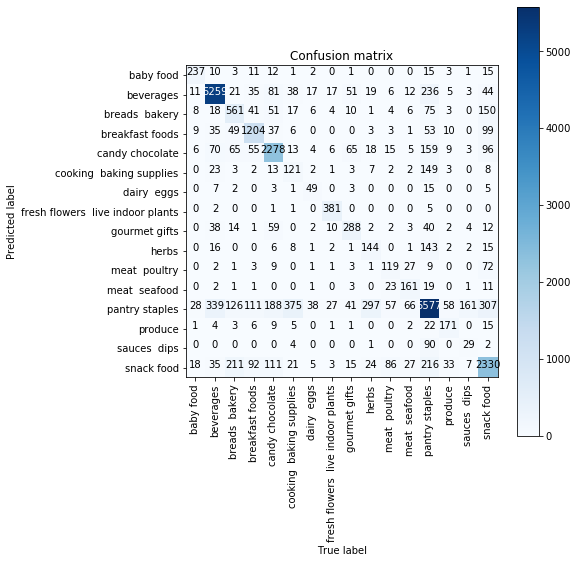

In [20]:
plot_confusion_matrix(y_valid, valid_pred, 
                      category2_classes, figsize=(8, 8))

#### Visualizing coefficients

In [21]:

def visualize_coefficients(classifier_coefs, feature_names, 
                           n_top_features=25, title='Coefs', 
                           save_path=None):
    # get coefficients with large absolute values 
    coef = classifier_coefs.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, 
                                          positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" 
              for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), 
            coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), 
               feature_names[interesting_coefficients], 
               rotation=90, ha="right")
    plt.title(title);
    if save_path:
        plt.savefig(save_path, dpi=300);

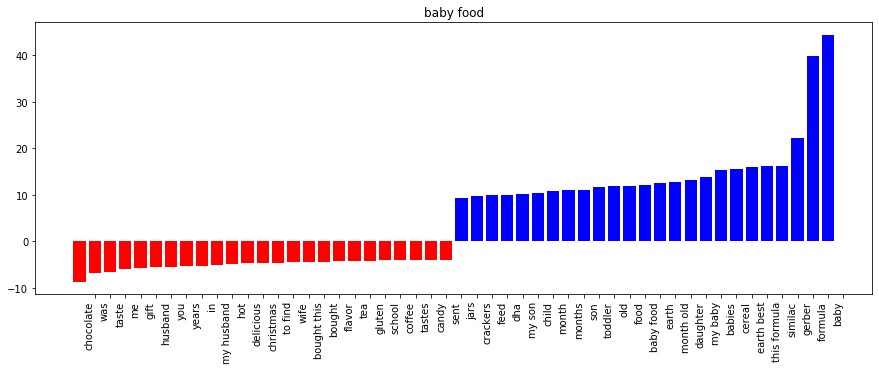

In [22]:
visualize_coefficients(tfidf_logit_pipeline.named_steps['logit'].coef_[0, :], 
                       tfidf_logit_pipeline.named_steps['tf_idf'].get_feature_names(),
                      title=category2_classes[0])

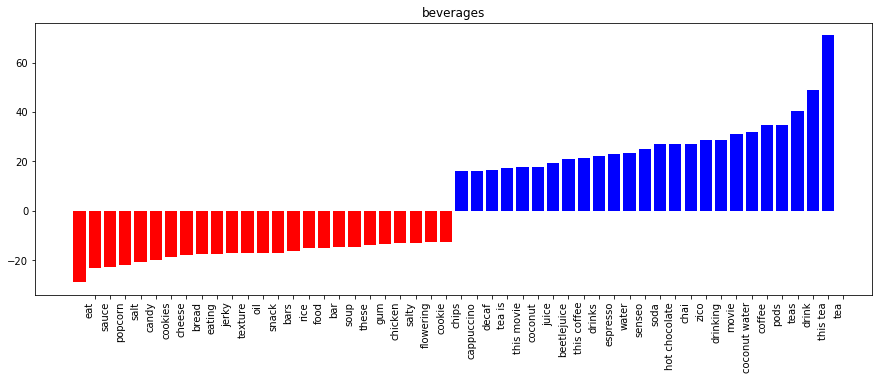

In [23]:
visualize_coefficients(tfidf_logit_pipeline.named_steps['logit'].coef_[1, :], 
                       tfidf_logit_pipeline.named_steps['tf_idf'].get_feature_names(),
                      title=category2_classes[1])

#### ELI5 ("Explain Like I'm 5")
ELI5 is a Python package which helps to debug machine learning classifiers and explain their predictions. It supports Sklearn, Xgboost, LightGBM and others. (https://github.com/TeamHG-Memex/eli5)

In [25]:
import eli5

In [26]:
eli5.show_weights(estimator=tfidf_logit_pipeline.named_steps['logit'],
                  vec=tfidf_logit_pipeline.named_steps['tf_idf'])

In [27]:
train_texts[0], y_train[0]

('While in Hungary we were given a recipe for Hungarian Goulash. It needs sweet paprika. This was terrific in that dish and others. I will purchase it again when I need more.',
 'herbs')

In [28]:
eli5.show_prediction(estimator=tfidf_logit_pipeline.named_steps['logit'],
                     vec=tfidf_logit_pipeline.named_steps['tf_idf'],
                     doc=train_texts[0])

#### Hierarchical text classification
Now we are going to predict categories 2 and 3 at the same time. It's not straightfoward how you make your category 3 predictions consistent with category 2 predictions. Example: if the model predicts "breakfast foods" as category 2, then it's obliged to predicts subcategories of "breakfast foods" as category 3, for instance, "cereals". But not "spices seasonings". Formally, it's called hierarchical text classification.

In [29]:
# combine categories 2 and 3
df['Cat2_Cat3'] = df['Cat2'] + '/' + df['Cat3']

In [30]:
y_cat2_and_cat3 = df['Cat2_Cat3']

In [31]:
y_cat2_and_cat3.head()

0    herbs/spices  seasonings
1     breakfast foods/cereals
2     breakfast foods/cereals
3     breakfast foods/cereals
4     breakfast foods/cereals
Name: Cat2_Cat3, dtype: object

In [32]:
train_texts, valid_texts,y_train_cat2_and_cat3, y_valid_cat2_and_cat3 = \
    train_test_split(texts, y_cat2_and_cat3, 
                     random_state=17,
                     stratify=y_cat2_and_cat3, 
                     shuffle=True)

In [33]:
tfidf_logit_pipeline.fit(train_texts, y_train_cat2_and_cat3)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  9.6min finished


Pipeline(steps=[('tf_idf',
                 TfidfVectorizer(max_features=50000, min_df=2,
                                 ngram_range=(1, 2))),
                ('logit',
                 LogisticRegression(C=100.0, multi_class='multinomial',
                                    n_jobs=4, random_state=17, verbose=1))])

In [34]:
valid_pred_cat2_and_cat3 = tfidf_logit_pipeline.predict(valid_texts)

In [35]:
cat2_pred = pd.Series(valid_pred_cat2_and_cat3).apply(lambda s: 
                                                      s.split('/')[0])
cat3_pred = pd.Series(valid_pred_cat2_and_cat3).apply(lambda s: 
                                                      s.split('/')[1])

In [36]:
y_valid_cat2 = pd.Series(y_valid_cat2_and_cat3).apply(lambda s: 
                                                      s.split('/')[0])
y_valid_cat3 = pd.Series(y_valid_cat2_and_cat3).apply(lambda s: 
                                                      s.split('/')[1])

In [37]:
accuracy_score(y_valid_cat3, cat3_pred)

0.6370619299087854

In [38]:
accuracy_score(y_valid_cat2, cat2_pred)


0.758801408225316